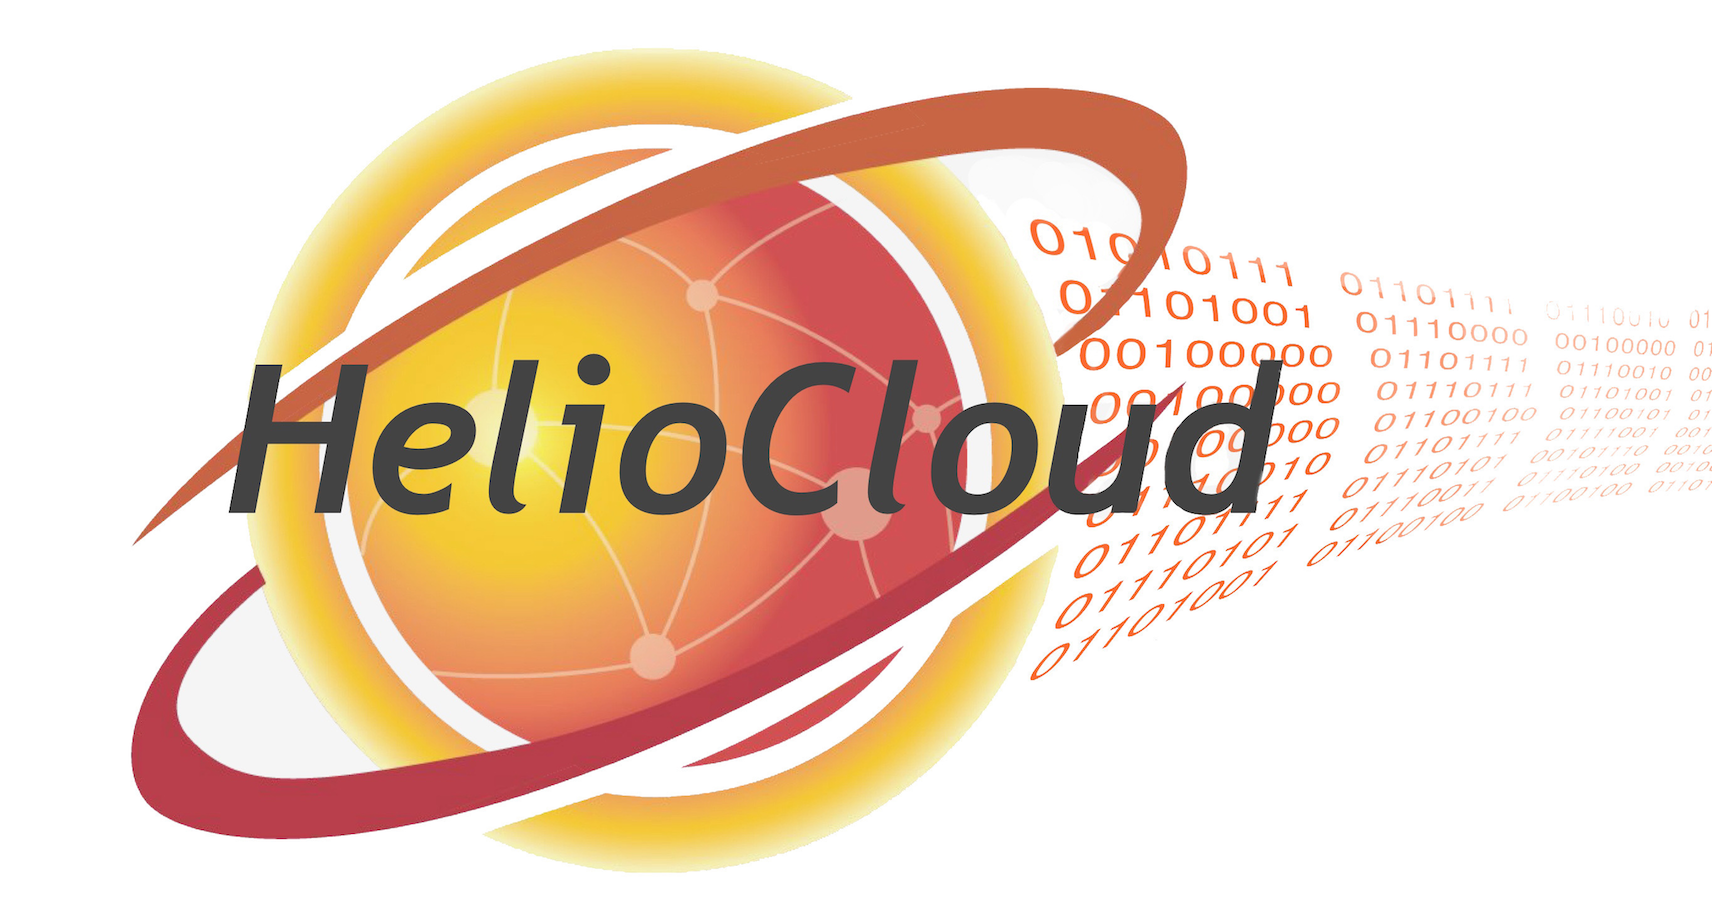
# AWS's big cheap disks (S3) Explained

Sandy Antunes (APL) Feb 2024 (Questions? Reach us at https://groups.io/g/heliocloud)

## * S3 is Amazon's big cheap disk storage
## * It is designed for sharing & keeping things cheap
## * Technically, it is not a 'file system' but an 'object store' (like a DB)
## * Sometimes that 'breaks' libraries expecting a file, not object
## * Prediction: in 1 year this will be moot


# Problems with using S3

## > **Cannot append to S3, only read or write!**
### (hence not suitable for databases, logs)
## > Not all libraries are able to deal with objects (whether S3 or from other libraries)

First, a quick sanity check to make sure Python is up and running.

In [ ]:
print("hello world")

Now a quick example of copying 3 files from S3 to the local disk.  Note this is for demo purposes only, generally you want to analyze your data in-place in S3 rather than copying them over!

In [ ]:
import os
import boto3
os.makedirs('demo-data', exist_ok=True)
s3 = boto3.resource('s3')
BUCKET_NAME = 'gov-nasa-hdrl-data1'
myfiles = ['demo-data/'+k for k in ['guvi_spect.nc','mms_fgm.cdf','sdo_aia.fits']]
for f in myfiles:
    s3.Bucket(BUCKET_NAME).download_file(f,f)


In [ ]:
# Basic imports needed
import cdflib
import astropy.io.fits
import matplotlib.pyplot as plt

def quickplotcdf(data):
    x = cdfin1.varget("Epoch")
    y = cdfin1.varget("mms1_fgm_b_gsm_brst_l2")
    plt.plot(x,y)
    plt.show()

def quickplotfits(hdu):
    import numpy as np
    data=hdu[1].data
    plt.imshow(data > 0)
    plt.show()

## For well-behaved libraries that are S3-aware, no action needed!
Here is the code to plot some MMS data (CDF file format). It requires no modification to read local files or S3 files.

In [ ]:
# CDF read of a local file
fname = "demo-data/mms_fgm.cdf"

cdfin1=cdflib.CDF(fname)
quickplotcdf(cdfin1)


In [ ]:
# CDF reading from S3 cloud
fname="s3://gov-nasa-hdrl-data1/demo-data/mms_fgm.cdf"

cdfin1=cdflib.CDF(fname)
quickplotcdf(cdfin1)

In [ ]:
# CDF reading in a URL
fname="https://gov-nasa-hdrl-data1.s3.amazonaws.com/demo-data/mms_fgm.cdf"

cdfin1=cdflib.CDF(fname)
quickplotcdf(cdfin1)

# Yay, no difference:

## > _fname = "pydata/mms_fgm.cdf"_

## > _fname="s3://helio-public/skantunes/mms_fgm.cdf_

## > _fname="https://helio-public.s3.amazonaws.com/skantunes/mms_fgm.cdf"_


# Problem: packages that expect a filename and don't take file pointers or bytestreams!

e.g. pyrfu

## Solutions:
## 1) _wait for package to be updated_
## 2) _mod the package yourself_
## 3) _copy from S3 to local disk and read from there (ugh, hacky)_

Fortunately the PyHC community is converging on a few standard file readers, and the rest of the libraries accepting both files and pointers to file data.

# HelioCloud-specific coolness with our S3 datasets (CDAWeb, SDO, MMS, etc)

## HC's big data holdings use an index format called _CloudCatalog_ that includes a python client for quickly pulling filelists based on mission, instrument, time range.

Here we query 'the entire set of S3 holdings HelioCloud knows of' to get **mms1_feeps_brst_electron** data for Feb 1, 2020.  The result is a pandas dataframe of _date_, _file_, _filesize_, that you can now loop through or feed into your code.

In [ ]:
# HelioCloud-specific coolness with our S3 datasets (CDAWeb, SDO, MMS, etc)
import cloudcatalog

fr=cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/",cache=False)
# one sample instruments and a time range
dataset_id1 = 'MMS1_FEEPS_BRST_L2_ELECTRON'
start = '2020-02-01T00:00:00Z'
stop =   '2020-02-02T00:00:00Z'

filekeys_id1 = fr.request_cloud_catalog(dataset_id1,start_date=start,stop_date=stop)
print("filekeys for ",dataset_id1,start,stop,":\n",filekeys_id1)

# Specifics-- Accessing FITS, CDF and NetCDF from S3
## Comments to sandy.antunes@jhuapl.edu
Here we walk through how to access FITS files, CDF files, and NetCDF files that are in AWS S3 storage.  Each cell can be run on its own, with the python import lines in each cell.  Let's begin. We connect to our S3 bucket. We'll later use different connections, depending on the file, but this is a good example of how to access S3.

In [ ]:
import boto3
mybucket='gov-nasa-hdrl-data1'
s3_res = boto3.resource('s3')
s3_bucket = s3_res.Bucket(mybucket)

And here is our list of potential files to try, from the GUVI, MMS and PSP missions.  (You can skip the commented-out boxes, again provided to add alternative test cases.)

Here is an example of a 'raw' read, where we access any binary file and extract information.  In this example, we open a CDF file as bytes then extract the checksum 'magic number' first field from it (which should read as 'cdf30001').

In [ ]:
import boto3
import io
# S3 read specific bytes
s3c = boto3.client('s3')

mykey='demo-data/mms_fgm.cdf'
obj = s3c.get_object(Bucket=mybucket,Key=mykey,Range='bytes=0-8')
rawdata=obj['Body'].read()
bdata=io.BytesIO(rawdata)

magic_number=bdata.read(4).hex()
print("Should print 'cdf30001' if read was correct:",magic_number)

## The Core Examples
Here is the code to read each file, in brief.  We'll then go into each in more depth.

In [ ]:
# CDF reading from S3 cloud
import cdflib
s3name="s3://gov-nasa-hdrl-data1/demo-data/mms_fgm.cdf"
with cdflib.CDF(s3name) as cdfin1:
    print(cdfin1.cdf_info())

In [ ]:
# CDF reading in a URL
import cdflib
s3name="https://gov-nasa-hdrl-data1.s3.amazonaws.com/demo-data/mms_fgm.cdf"
with cdflib.CDF(s3name) as cdfin1:
    print(cdfin1.cdf_info())

In [ ]:
# FITS, using s3fs, reading from S3 cloud
import astropy.io.fits
# note some versions of AstroPy can be compiled to open S3 files directly, with no intermediary
s3name="s3://gov-nasa-hdrl-data1/demo-data/sdo_aia.fits"
try:
    data = astropy.io.fits.open(s3name)
    print("astropy was compiled with S3 support!")
except:
    print("astropy was not compiled with S3 support, using 's3fs'")
    import s3fs
    fs=s3fs.S3FileSystem(anon=False)
    fgrab = fs.open(s3name)
    data = astropy.io.fits.open(fgrab)

print(data[0].header[0:10])

In [ ]:
# NetCDF via xarray, using s3fs, reading from S3 cloud
import s3fs
import xarray as xr
s3name="s3://gov-nasa-hdrl-data1/demo-data/guvi_spect.nc"
fs=s3fs.S3FileSystem(anon=False)
fgrab = fs.open(s3name)
dataset = xr.open_dataset(fgrab)
print(dataset)
dataset.close()
fgrab.close()

In [ ]:
# Example of reading in a file as a Bytestream for using a non-S3-aware reader (in this case, AstroPy)
import astropy.io.fits
import io
import boto3

s3c = boto3.client('s3')
mybucket, mykey = 'gov-nasa-hdrl-data1', 'demo-data/sdo_aia.fits'

fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
rawdata = fobj['Body'].read()
bdata = io.BytesIO(rawdata)
data = astropy.io.fits.open(bdata,memmap=False)

header = data[0].header
print(header[0:10])


# Conclusions

## > S3 is 'nearly there' in terms of being transparent and useable
## > You will run into less-used packages that require some hackery
## > Over time, others will likely solve this for you
## > But 'cannot append to S3 files' will be a going concern
(because S3 is object store, not a file.  But it is cheap!)

Comments? Feel free to contact the author.

# Advanced: Readying S3 as raw bytes
## useful for Developers

Here is an example of a 'raw' read, where we access any binary file and extract information.  In this example, we open a CDF file as bytes then extract the checksum 'magic number' first field from it (which should read as 'cdf30001').


In [ ]:
import boto3
import io
s3c = boto3.client('s3')

mybucket, mykey = 'gov-nasa-hdrl-data1', 'demo-data/mms_fgm.cdf'
obj = s3c.get_object(Bucket=mybucket,Key=mykey,Range='bytes=0-8')
rawdata=obj['Body'].read()
bdata=io.BytesIO(rawdata)

magic_number=bdata.read(4).hex()
print("Should print 'cdf30001' if read was correct:",magic_number)

In [ ]:
# Example of reading in a file as a Bytestream for using a non-S3-aware reader (in this case, AstroPy)
import astropy.io.fits
import io
import boto3

s3c = boto3.client('s3')
mybucket, mykey = 'gov-nasa-hdrl-data1', 'demo-data/sdo_aia.fits'

fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
rawdata = fobj['Body'].read()
bdata = io.BytesIO(rawdata)
hdu = astropy.io.fits.open(bdata,memmap=False)

quickplotfits(hdu)

## Additional notes on SunPy

SunPy does not always accept S3. If it is not built against the current astropy, it will throw an error, as shown here.

In [ ]:
import sunpy.map
fname = "demo-data/sdo_aia.fits"
map_from_fits = sunpy.map.Map(fname)
print("Works, reading a local file into SunPy")

fname="s3://gov-nasa-hdrl-data1/demo-data/sdo_aia.fits"
try:
    map_from_fits = sunpy.map.Map(fname)
    print("Works, reading an S3 file into SunPy")
except Exception as e:
      print(f"Could not read from {fname}, SunPy error thrown was: {e}")

There are different workarounds to read FITS into SunPy.  For example:

In [ ]:
import sunpy.map
import astropy.io.fits
fname="s3://gov-nasa-hdrl-data1/demo-data/sdo_aia.fits"
hdu = astropy.io.fits.open(fs.open(fname))
map_from_fits = sunpy.map.Map(hdu[1].data,hdu[1].header)
fgrab.close()
map_from_fits.peek(vmin=0)
print("Using astropy to feed into SunPy worked!")

# Dealing with a non-S3-aware library

Here we try to read a PSP WISPR image in FITS format.

In [ ]:
fname = "demo-data/sdo_aia.fits"
hdu = astropy.io.fits.open(fname)
quickplotfits(hdu)

# Note-- to see what Python throws on an S3 read failure:
In order to force an error, run using an older kernel (e.g. 'ipykernel'), run next cell, then switch back to 'panhelio-notebook' and re-run. Builds using the older non-S3-aware astropy will fail, while later versions are S3-aware.

In [ ]:
# this will fail using older versions of astropy
import astropy.io.fits
fname = "s3://gov-nasa-hdrl-data1/demo-data/sdo_aia.fits"
try:
    data = astropy.io.fits.open(fname)
    print("Worked, reading an S3 file into AstroPy")
except Exception as e:
      print(f"Could not read from {fname}, AstroPy error thrown was: {e}")

##### Workarounds as of 2024
* Install latest 'astropy' with optional S3-aware toggles!
* Or, use the 's3fs' package as a file-izer (?)

In [ ]:
# FITS, using s3fs, reading from S3 cloud
import s3fs

fname="s3://gov-nasa-hdrl-data1/demo-data/sdo_aia.fits"
fs=s3fs.S3FileSystem(anon=False)
fgrab = fs.open(fname)
hdu = astropy.io.fits.open(fgrab)
quickplotfits(hdu)
fgrab.close()
# note some versions of AstroPy can be compiled to open S3 files directly, with no intermediary

# How the workaround works
## Previous: 
## > _astropy.io.fits(fname)_

## New: open a file-like handle using the 's3fs' package, open that, and send that file pointer to astropy

## > _fgrab = s3fs.S3FileSystem(anon=False).open(fname)_

## > _astropy.io.fits(fgrab)_

## You can use the same 's3fs' technique for NetCDF via xarray...

In [ ]:
# NetCDF via xarray, using s3fs, reading from S3 cloud
import s3fs
import xarray as xr

s3name="s3://gov-nasa-hdrl-data1/demo-data/guvi_spect.nc"
fs=s3fs.S3FileSystem(anon=False)
fgrab = fs.open(s3name)
dataset = xr.open_dataset(fgrab)

print(dataset)
dataset.close()
fgrab.close()